In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd /content/drive/MyDrive/Recommended_Systems/ml-latest-small

/content/drive/MyDrive/Recommended_Systems/ml-latest-small


In [8]:
movielens_dir = "/content/drive/MyDrive/Recommended_Systems/ml-latest-small" 
ratings_file =  "/content/drive/MyDrive/Recommended_Systems/ml-latest-small/ratings.csv" 

df = pd.read_csv(ratings_file)
print(df)

        userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[100836 rows x 4 columns]


In [9]:
movie_names=pd.read_csv("/content/drive/MyDrive/Recommended_Systems/ml-latest-small/movies.csv")

movie_data = pd.merge(df,movie_names,on='movieId')
movie_data = movie_data.drop(['genres','timestamp'],axis= 1)

print(movie_data)

        userId  movieId  rating                             title
0            1        1     4.0                  Toy Story (1995)
1            5        1     4.0                  Toy Story (1995)
2            7        1     4.5                  Toy Story (1995)
3           15        1     2.5                  Toy Story (1995)
4           17        1     4.5                  Toy Story (1995)
...        ...      ...     ...                               ...
100831     610   160341     2.5                  Bloodmoon (1997)
100832     610   160527     4.5  Sympathy for the Underdog (1971)
100833     610   160836     3.0                     Hazard (2005)
100834     610   163937     3.5                Blair Witch (2016)
100835     610   163981     3.5                         31 (2016)

[100836 rows x 4 columns]


In [10]:
# Tạo Dataframe để thống kê
trend=pd.DataFrame(movie_data.groupby('title')['rating'].mean())
trend['total number of ratings'] = pd.DataFrame(movie_data.groupby('title')['rating'].count()) 
print(trend)

                                             rating  total number of ratings
title                                                                       
'71 (2014)                                 4.000000                        1
'Hellboy': The Seeds of Creation (2004)    4.000000                        1
'Round Midnight (1986)                     3.500000                        2
'Salem's Lot (2004)                        5.000000                        1
'Til There Was You (1997)                  4.000000                        2
...                                             ...                      ...
eXistenZ (1999)                            3.863636                       22
xXx (2002)                                 2.770833                       24
xXx: State of the Union (2005)             2.000000                        5
¡Three Amigos! (1986)                      3.134615                       26
À nous la liberté (Freedom for Us) (1931)  1.000000                        1

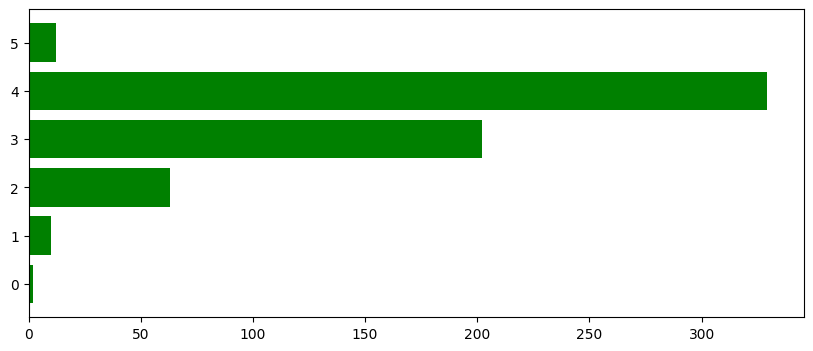

In [11]:
#plot ratings with number of movies
plt.figure(figsize =(10, 4))
ax=plt.barh(trend['rating'].round(),trend['total number of ratings'],color='g')
plt.show()

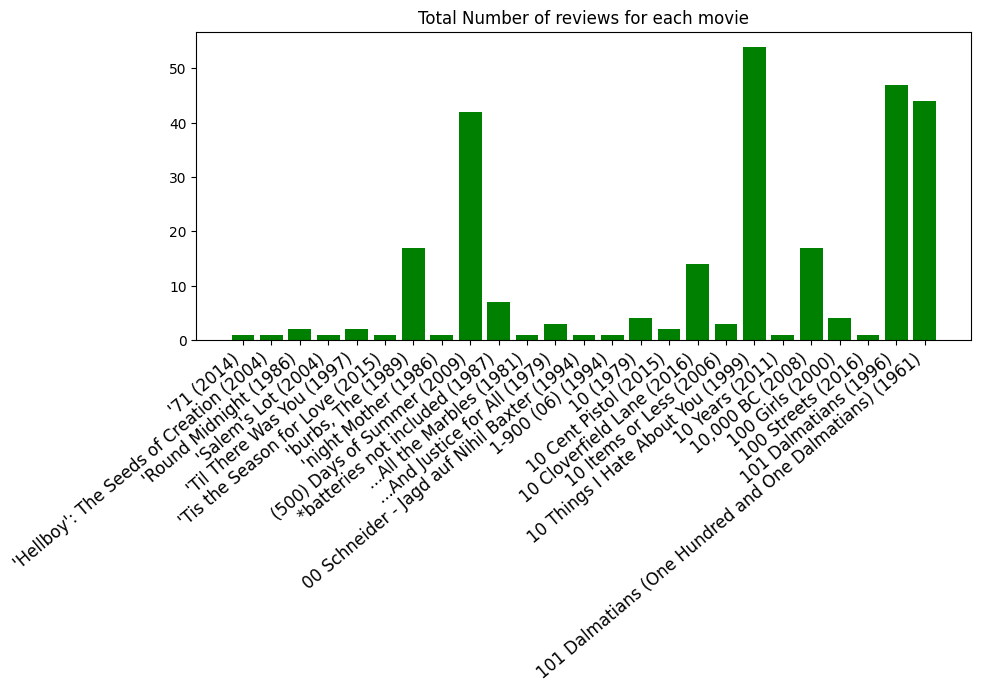

In [12]:
#a bar graph 25 movies
plt.figure(figsize=(10, 4))
ax = plt.subplot()
ax.bar(trend.head(25).index, trend['total number of ratings'].head(25), color='g')
ax.set_xticks(trend.head(25).index)
ax.set_xticklabels(trend.head(25).index, rotation=40, fontsize='12', horizontalalignment="right")
ax.set_title("Total Number of reviews for each movie")
plt.show()


In [13]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)

min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [14]:
# Prepare training and validation data

df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Chia tập dữ liệu 
train_indices = int(0.75 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)


In [15]:
# Create the model
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

# model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
# model.compile(
#     loss=tf.keras.losses.BinaryCrossentropy(), 
#     optimizer=keras.optimizers.Adam(learning_rate=0.001),
#     metrics=["mean_absolute_error", "mean_squared_error"]
# )

In [16]:
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE,)
model.compile( 
    keras.optimizers.Adam(learning_rate=0.001), 
    loss="mean_squared_error",
    metrics=["mean_absolute_error", "mean_squared_error"])

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1182/1182 [==============================] - 14s 11ms/step - loss: 0.0553 - mean_absolute_error: 0.1888 - mean_squared_error: 0.0551 - val_loss: 0.0472 - val_mean_absolute_error: 0.1710 - val_mean_squared_error: 0.0469
Epoch 2/5
1182/1182 [==============================] - 19s 16ms/step - loss: 0.0448 - mean_absolute_error: 0.1657 - mean_squared_error: 0.0444 - val_loss: 0.0471 - val_mean_absolute_error: 0.1746 - val_mean_squared_error: 0.0467
Epoch 3/5
1182/1182 [==============================] - 11s 9ms/step - loss: 0.0421 - mean_absolute_error: 0.1590 - mean_squared_error: 0.0416 - val_loss: 0.0450 - val_mean_absolute_error: 0.1685 - val_mean_squared_error: 0.0443
Epoch 4/5
1182/1182 [==============================] - 11s 9ms/step - loss: 0.0411 - mean_absolute_error: 0.1564 - mean_squared_error: 0.0404 - val_loss: 0.0435 - val_mean_absolute_error: 0.1637 - val_mean_squared_error: 0.0427
Epoch 5/5
1182/1182 [==============================] - 11s 10ms/step - loss: 0.0408 - 

In [17]:
model.summary()

Model: "recommender_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  30500     
                                                                 
 embedding_1 (Embedding)     multiple                  610       
                                                                 
 embedding_2 (Embedding)     multiple                  486200    
                                                                 
 embedding_3 (Embedding)     multiple                  9724      
                                                                 
Total params: 527,034
Trainable params: 527,034
Non-trainable params: 0
_________________________________________________________________


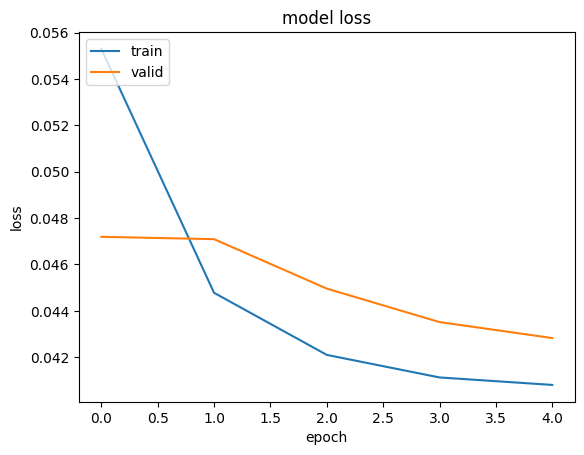

In [18]:
# Plot training and validation loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "valid"], loc="upper left")
plt.show()


In [19]:
user_id = 57
movies_watched_by_user = df[df.userId == user_id]

# Print  movies watched by user
print(movies_watched_by_user)

      userId  movieId  rating  timestamp  user  movie
8341      57     2102     4.0  965796031    56   3024
8035      57        1     5.0  965796031    56      0
8309      57     1784     4.0  972172894    56    729
8180      57     1036     4.0  969754215    56   1134
8229      57     1270     4.0  965798685    56     85
...      ...      ...     ...        ...   ...    ...
8335      57     2081     5.0  965796107    56   1034
8308      57     1769     2.0  969754612    56   2672
8155      57      899     5.0  965796563    56    330
8110      57      551     4.0  969753400    56   1419
8392      57     2628     3.0  965798332    56    171

[476 rows x 6 columns]


In [20]:
movie_df = pd.read_csv("/content/drive/MyDrive/Recommended_Systems/ml-latest-small/movies.csv")

movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)

movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-5:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 5 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)


289/289 [==============================] - 2s 6ms/step
Showing recommendations for user: 57
Movies with high ratings from user
--------------------------------
Usual Suspects, The (1995) : Crime|Mystery|Thriller
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Chinatown (1974) : Crime|Film-Noir|Mystery|Thriller
Duck Soup (1933) : Comedy|Musical|War
--------------------------------
Top 5 movie recommendations
--------------------------------
Shawshank Redemption, The (1994) : Crime|Drama
In the Name of the Father (1993) : Drama
Goodfellas (1990) : Crime|Drama
American History X (1998) : Crime|Drama
Dark Knight, The (2008) : Action|Crime|Drama|IMAX


In [22]:
import joblib

joblib.dump(model, 'collaborative_filtering_model.pkl')


['collaborative_filtering_model.pkl']

In [ ]:
from flask import Flask, request, jsonify
import joblib

app = Flask(__name__)

# Load the model
model = joblib.load('collaborative_filtering_model.pkl')

# Endpoint for recommending movies to a user
@app.route('/recommend/<int:user_id>')
def recommend(user_id):
    recommendations = model.recommend(user_id)
    return jsonify(recommendations)

if __name__ == '__main__':
    app.run()
